<a href="https://colab.research.google.com/github/squashai/notebooks/blob/main/baseline_court_keypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline estimation of squash court keypoints

This notebook trains a convolutional neural network inspired by [Simple Baselines for Human Pose Estimation and Tracking
](https://paperswithcode.com/paper/simple-baselines-for-human-pose-estimation) on the [SquashAI player position dataset](https://github.com/squashai/datasets).

[![SQUASHAI](https://img.shields.io/badge/SQUASH-AI-black)](https://squashai.github.io)
[![View source on Github](https://img.shields.io/badge/-View%20source%20on%20Github-blue?logo=github&labelColor=black)](https://github.com/squashai/notebooks/blob/main/baseline_court_keypoints.ipynb)


# Initialization

## Dataset Retrievial

In [2]:
%cd /content/
!curl -L --output datasets+img.tar.gz https://github.com/squashai/datasets/releases/download/0.0.6/datasets+img.tar.gz
!tar zxf datasets+img.tar.gz

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   647  100   647    0     0   2588      0 --:--:-- --:--:-- --:--:--  2598
100  228M  100  228M    0     0  30.2M      0  0:00:07  0:00:07 --:--:-- 35.9M


In [3]:
%cd /content/datasets+img/

/content/datasets+img


## Imports and Variables

In [4]:
# imports for data handling
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import shutil
from random import random
# imports for model handling
from tensorflow import keras
from keras.models import Sequential, Model, load_model
from keras.layers import (
    Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, MaxPool2D
)
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.utils import plot_model

In [5]:
# downloaded dataset
DATASET_DIR = '.'
DATASET_FILE = os.path.join(DATASET_DIR, 'images.csv')

# image size for model training and testing
MODEL_INPUT_SIZE = (108, 192)

# gaussian Sigma for model heatmaps
HEATMAP_SIGMA = 10

# zoom factor
MAX_ZOOM_FACTOR = 1.3

# model variables
NUM_EPOCHS = 100
BATCH_SIZE = 128
BEST_MODEL_FILE = 'best_bl-points_model.hdf5'
LAST_MODEL_FILE = 'last_bl-points_model.hdf5'

# path to final store for models (should be persistent)
PERSISTENT_MODELS_DIR = '/content/drive/My Drive/colab-data'

In [6]:
# dataset data
images = []
boxes = []

# train, test and evaluation data
model_images = []
model_boxes = []
model_heatmaps = []

## Data Preparation

### Data Extraction

In [7]:
images.clear()
boxes.clear()

data_frame = pd.read_csv(DATASET_FILE, sep=';')
for idx, row in data_frame[:].iterrows():
    image = np.array(mpimg.imread(os.path.join(DATASET_DIR, row.filename)))
    box = np.reshape(np.array(row[1:], dtype=float), (-1, 2))
    images.append(image)
    boxes.append(box)

#### Inspection

In [8]:
print('Shape of images: {}'.format(np.shape(images)))
print('Shape of boxes: {}'.format(np.shape(boxes)))

Shape of images: (1253, 720, 1280, 3)
Shape of boxes: (1253, 4, 2)


### Helper Functions

#### Plotting Functions

In [9]:
def plot_image(image=None, box=None, heatmap=None):
    plt.figure(figsize=(10, 10))
    if image is not None:
        if hasattr(image, 'dtype') and image.dtype == np.float16:
            plt.imshow(np.array(image, dtype=np.float32))
        else:
            plt.imshow(image)

    if box is not None:
        for idx, label in enumerate(['tl', 'tr', 'br', 'bl']):
            x, y = box[idx]
            if not np.any(np.isnan([x, y])):
                plt.scatter(x, y, s=20, marker='.', color='red')
                plt.text(x, y, label, color='red', fontsize=20)

    if heatmap is not None:
        if image is not None:
            h, w = np.shape(image)[:2]
        else:
            h, w = np.shape(heatmap)[:2]
        n = np.shape(heatmap)[-1]

        rgba = np.zeros((h, w, 4))
        rgba[:, :, 0] = heatmap[:h, :w, 0] + heatmap[:h, :w, 1]
        rgba[:, :, 1] = heatmap[:h, :w, 1] + heatmap[:h, :w, 2]
        rgba[:, :, 2] = heatmap[:h, :w, 2] + heatmap[:h, :w, 3]
        rgba[:, :, 3] = (
            heatmap[:h, :w, 0] + heatmap[:h, :w, 1] +
            heatmap[:h, :w, 2] + heatmap[:h, :w, 3]
        )
        max_val = rgba.max()
        if max_val > 0:
            rgba *= (1 / max_val)

        plt.imshow(rgba)

    plt.show()

##### Tests

In [ ]:
n = 50

image = images[n]
box = boxes[n]

plot_image(image)
plot_image(image, box)

#### Heatmap Functions

In [11]:
def point_to_layer(point, output_size, sigma):
    if np.any(np.isnan(point)):
        return np.zeros(output_size)
    else:
        x0, y0 = point
        h, w = output_size
        if np.any(np.isnan(point)):
            return np.zeros(output_size)
        x = np.arange(0, w, 1, float)
        y = np.arange(0, h, 1, float)[:, np.newaxis]
        return np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

def box_to_heatmap(box, output_size, sigma):
    h, w = output_size
    heatmap = np.zeros((h, w, len(box)), dtype=np.float16)
    for idx in range(len(box)):
        heatmap[:, :, idx] = point_to_layer(box[idx], output_size, sigma)
    return heatmap

In [12]:
def layer_to_point(hm_layer, num_points=4, threshold=0.2):
    ## pick the largest num_points
    ind = hm_layer.argsort(axis=None)[-num_points:]
    topind = np.unravel_index(ind, np.shape(hm_layer))
    index = np.unravel_index(hm_layer.argmax(), np.shape(hm_layer))
    y, x, hsum = 0, 0, 0
    for ind in zip(topind[0],topind[1]):
        h  = hm_layer[ind[0],ind[1]]
        hsum += h
        y   += ind[0]*h
        x   += ind[1]*h

    if hsum / num_points <= threshold:
        y, x = float('NaN'), float('NaN')
    else:
        y /= hsum
        x /= hsum
 
    return [x, y]

def heatmap_to_box(heatmap, num_points=4, threshold=0.2):
    box = []
    for l in range(np.shape(heatmap)[-1]):
        box.append(layer_to_point(heatmap[:, :, l], num_points, threshold))

    return box

##### Tests

In [ ]:
n = 0

image = images[n]
box = boxes[n]
heatmap = box_to_heatmap(box, np.shape(image)[:2], 10)

plot_image(image, box)
plot_image(image, heatmap=heatmap)
plot_image(image, box=heatmap_to_box(heatmap))
for idx in range(np.shape(heatmap)[-1]):
    plot_image(heatmap[:, :, idx])

#### Scaling Functions

In [14]:
def scale_image(image, output_size):
    h, w = image.shape[:2]
    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size

    new_h, new_w = int(new_h), int(new_w)
    new_image = cv2.resize(image, (new_w, new_h))
    return new_image

def scale_box(box, input_size, output_size):
    h, w = input_size[0:2]
    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size
    new_box = box * [new_w / w, new_h / h]
    return new_box

def scale(image, output_size, box=None):
    new_img = scale_image(image, output_size)
    if box is not None:
        new_box = scale_box(box, np.shape(image), output_size)
        return new_img, new_box
    return new_img

##### Tests

In [ ]:
n = 20
downscale = (72, 128)
upscale = (1080, 1920)

image = images[n]
box = boxes[n]
small_image, small_box = scale(image, downscale, box)
small_heatmap = box_to_heatmap(small_box, np.shape(small_image)[:2], 2)

plot_image(image, box)
plot_image(small_image, heatmap=small_heatmap)
plot_image(small_image, small_box, small_heatmap)
plot_image(*scale(image, upscale, box))


#### Cropping Functions

In [16]:
def crop_image(image, output_size):
    h, w = image.shape[:2]
    if isinstance(output_size, int):
        new_h, new_w = (output_size, output_size)
    else:
        new_h, new_w = output_size
    top = int((h - new_h) / 2)
    left = int((w - new_w) / 2)

    image = image[top : top + new_h,
                  left : left + new_w]
    return image

def crop_box(box, input_size, output_size):
    h, w = input_size[0:2]
    if isinstance(output_size, int):
        new_h, new_w = (output_size, output_size)
    else:
        new_h, new_w = output_size
    top = int((h - new_h) / 2)
    left = int((w - new_w) / 2)
    new_box = box - [left, top]
    cropped = (
        (new_box[:,0] > new_w) | (new_box[:, 1] > new_h) |
        (new_box[:,0] < 0) | (new_box[:, 1] < 0)
    )
    new_box[cropped] = [float('NaN'), float('NaN')]
    return new_box

def crop(image, output_size, box=None):
    new_img = crop_image(image, output_size)
    if box is not None:
        new_box = crop_box(box, np.shape(image), output_size)
        return new_img, new_box

    return new_img


##### Tests

In [ ]:
n = 20
downsize = (500, 500)

image = images[n]
box = boxes[n]
small_image, small_box = crop(image, downsize, box)
small_heatmap = box_to_heatmap(small_box, np.shape(small_image)[:2], 15)

plot_image(image, box)
plot_image(small_image, heatmap=small_heatmap)
plot_image(small_image, small_box, small_heatmap)

#### Zoom Functions

In [18]:
def zoom_image(image, factor):
    new_size = np.array(image.shape[:2]) * factor
    new_image = scale_image(image, new_size)
    return crop_image(new_image, np.shape(image)[:2])

def zoom_box(box, input_size, factor):
    new_size = np.array(input_size) * factor
    new_box = scale_box(box, input_size, new_size)
    return crop_box(new_box, new_size, input_size)

def zoom(image, factor, box=None):
    new_img = zoom_image(image, factor)
    if box is not None:
        new_box = zoom_box(box, np.shape(image)[:2], factor)
        return new_img, new_box

    return new_img

##### Tests

In [ ]:
n = 500
factor = 1.2

image = images[n]
box = boxes[n]
zoomed_image, zoomed_box = zoom(image, factor, box)
zoomed_heatmap = box_to_heatmap(zoomed_box, np.shape(zoomed_image)[:2], 20)

plot_image(image, box)
plot_image(zoomed_image, zoomed_box, zoomed_heatmap)
plot_image(*zoom(image, factor, box))

#### Flipping Functions

In [20]:
def flip_image(image):
    img = cv2.flip(image, 1)
    return img

def flip_box(box, input_size):
    center = input_size[1] / 2
    new_box = np.array([
        box[1], box[0], box[3], box[2]
    ])
    new_box[:, 0] = 2 * center - new_box[:, 0]
    return new_box

def flip(image, box=None):
    new_img = flip_image(image)
    if box is not None:
        new_box = flip_box(box, np.shape(image))
        return new_img, new_box
    return new_img

##### Tests

In [ ]:
n = 50

image = images[n]
box = boxes[n]
heatmap = box_to_heatmap(box, np.shape(image)[:2], 20)
flipped_image, flipped_box = flip(image, box)
flipped_heatmap = box_to_heatmap(flipped_box, np.shape(flipped_image)[:2], 20)

plot_image(image, box, heatmap)
plot_image(flipped_image, flipped_box, flipped_heatmap)

#### Persistance Functions

In [22]:
def persist(filename):
    shutil.copy(filename, os.path.join(PERSISTENT_MODELS_DIR, filename))

def restore(filename):
    shutil.copy(os.path.join(PERSISTENT_MODELS_DIR, filename), filename)

def unpersist(filename):
    os.remove(os.path.join(PERSISTENT_MODELS_DIR, filename))

##### Tests

In [23]:
!echo Hi > foobar
persist('foobar')
!rm foobar
!stat foobar
restore('foobar')
!cat foobar
!rm foobar
unpersist('foobar')
try:
    restore('foobar')
except:
    print('`restore()` correctly failed')

stat: cannot stat 'foobar': No such file or directory
Hi
`restore()` correctly failed


### Data Augmentation

In [24]:
model_images.clear()
model_boxes.clear()
model_heatmaps.clear()

def store(image, box, heatmap):
    model_images.append(image)
    model_boxes.append(box)
    model_heatmaps.append(heatmap)
    return image, box, heatmap

def downscale_and_store(image, box):
    scaled_image, scaled_box = scale(image, MODEL_INPUT_SIZE, box)
    scaled_heatmap = box_to_heatmap(scaled_box,
                                    MODEL_INPUT_SIZE, HEATMAP_SIGMA)
    return store(scaled_image, scaled_box, scaled_heatmap)[:2]

def flip_and_store(image, box):
    flipped_image, flipped_box = flip(image, box)
    flipped_heatmap = box_to_heatmap(flipped_box,
                                        MODEL_INPUT_SIZE, HEATMAP_SIGMA)
    return store(flipped_image, flipped_box, flipped_heatmap)[:2]


for idx in range(len(images[:])):
    # downscale and store
    #downscale_and_store(images[idx], boxes[idx])

    # downscale original and store, then flip and store again
    flip_and_store(*downscale_and_store(images[idx], boxes[idx]))
 
    # zoom original...
    zoomed_image, zoomed_box = zoom(images[idx],
                                    random() * (MAX_ZOOM_FACTOR - 1) + 1,
                                    boxes[idx])

    # ... then downscale zoomed and store, then flip zoomed downscaled
    # and store
    flip_and_store(*downscale_and_store(zoomed_image, zoomed_box))
 

#### Data Inspection

In [25]:
print('Shape of model images: {}'.format(np.shape(model_images)))
print('Shape of model boxes: {}'.format(np.shape(model_boxes)))
print('Shape of model heatmaps: {}'.format(np.shape(model_heatmaps)))

Shape of model images: (5012, 108, 192, 3)
Shape of model boxes: (5012, 4, 2)
Shape of model heatmaps: (5012, 108, 192, 4)


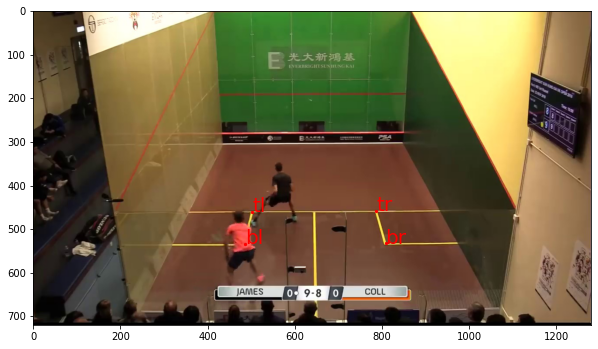

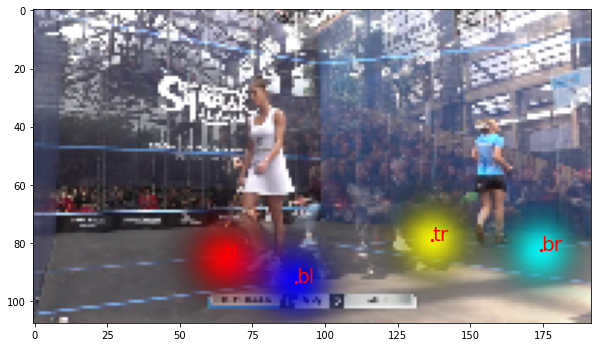

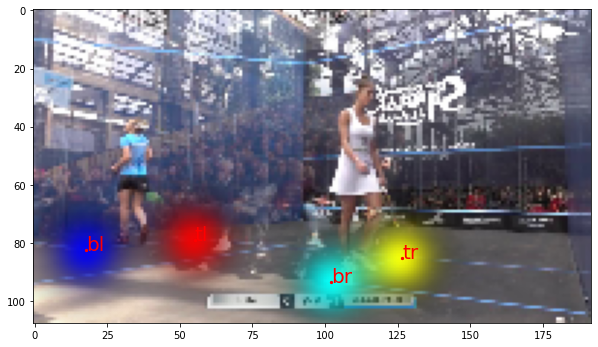

In [26]:
n = 965

plot_image(images[n], boxes[n])
for idx in range(n * 2, n * 2 + 2):
    plot_image(model_images[idx], model_boxes[idx], model_heatmaps[idx])


# Model Preparation

## Model Creation

94773248/94765736 [==============================] - 6s 0us/step


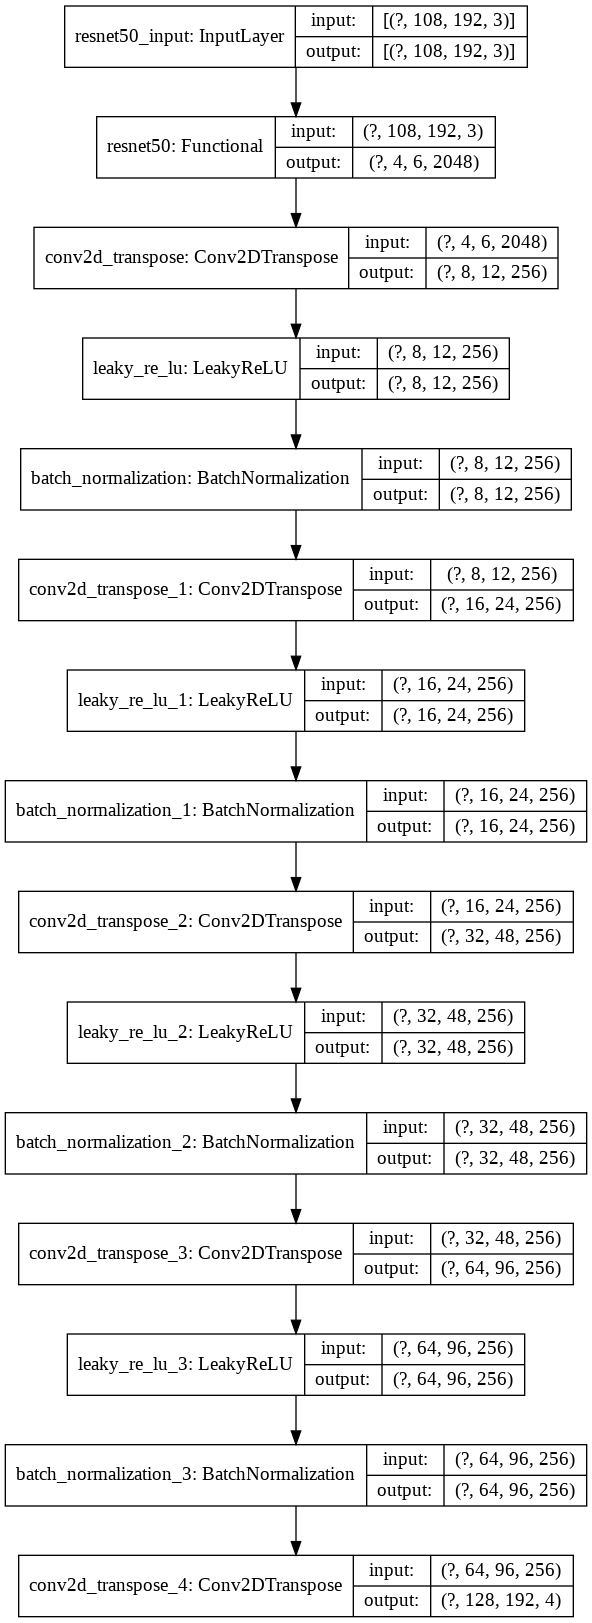

In [26]:
model = Sequential()
model.add(ResNet50(include_top=False, input_shape=np.shape(model_images)[1:]))
model.add(Conv2DTranspose(256, [4, 4], strides=2,
          padding='same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Conv2DTranspose(256, [4, 4], strides=2,
          padding='same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Conv2DTranspose(256, [4, 4], strides=2,
          padding='same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Conv2DTranspose(256, [4, 4], strides=2,
          padding='same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(Conv2DTranspose(4, [1, 1], strides=2,
          padding='same', activation=None))

plot_model(model, show_shapes=True)

### Output Adjustment

In [28]:
print('Model output shape: {}'.format(model.output_shape))
print('Heatmaps shape: {}'.format(np.shape(model_heatmaps)))

Model output shape: (None, 128, 192, 4)
Heatmaps shape: (5012, 108, 192, 4)


In [29]:
padded_heatmaps = np.pad(model_heatmaps[:], ((0, 0), (10, 10), (0, 0), (0, 0)))

In [30]:
# input and output oughta be numpy arrays (or tensors)
train_input = np.array(model_images)
train_output = padded_heatmaps

### Inspection

In [31]:
print('Model input shape: {}'.format(model.input_shape))
print('Train input shape: {}'.format(np.shape(train_input)))
print('Model output shape: {}'.format(model.output_shape))
print('Train output shape: {}'.format(np.shape(train_output)))

Model input shape: (None, 108, 192, 3)
Train input shape: (5012, 108, 192, 3)
Model output shape: (None, 128, 192, 4)
Train output shape: (5012, 128, 192, 4)


In [ ]:
n = 45


plot_image(heatmap=model_heatmaps[n])
plot_image(heatmap=train_output[n])
plot_image(model_heatmaps[n][:, :, 1])
plot_image(train_output[n][:,:,1])

## Model Training

In [32]:
# define necessary callbacks
checkpointer = ModelCheckpoint(filepath=BEST_MODEL_FILE, monitor='val_mae',
                               verbose=1, save_best_only=True, mode='min')

# compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error', metrics=['mae', 'acc'])

# Train the model
history = model.fit(train_input, train_output,
                    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split=0.05, callbacks=[checkpointer])

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.2226 - mae: 0.1326 - acc: 0.4670
Epoch 00001: val_mae improved from inf to 0.60037, saving model to best_bl-points_model.hdf5
38/38 [==============================] - 100s 3s/step - loss: 0.2226 - mae: 0.1326 - acc: 0.4670 - val_loss: 3.8314 - val_mae: 0.6004 - val_acc: 0.1976
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 0.0117 - mae: 0.0481 - acc: 0.2699
Epoch 00002: val_mae improved from 0.60037 to 0.07604, saving model to best_bl-points_model.hdf5
38/38 [==============================] - 96s 3s/step - loss: 0.0117 - mae: 0.0481 - acc: 0.2699 - val_loss: 0.0493 - val_mae: 0.0760 - val_acc: 0.4741
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.0108 - mae: 0.0431 - acc: 0.3147
Epoch 00003: val_mae improved from 0.07604 to 0.05607, saving model to best_bl-points_model.hdf5
38/38 [==============================] - 96s 3s/step - loss: 0.0108 - mae: 0.0431 - acc: 0.3147 - 

### Model Persist

In [33]:
model.save(LAST_MODEL_FILE)
persist(BEST_MODEL_FILE)
persist(LAST_MODEL_FILE)

### Learning Curves

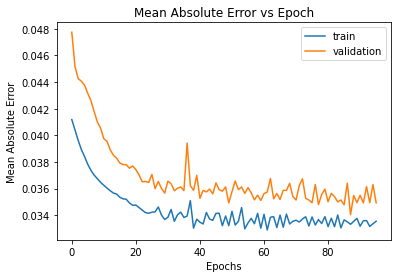

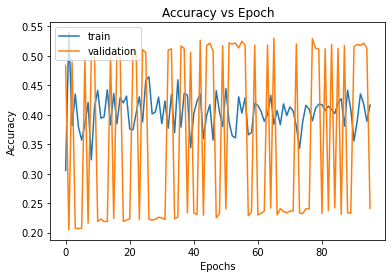

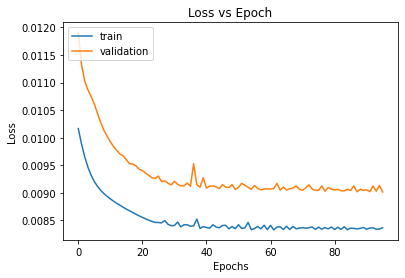

In [34]:
start = 4

# summarize history for mean_absolute_error
try:
    plt.plot(history.history['mae'][start:])
    plt.plot(history.history['val_mae'][start:])
    plt.title('Mean Absolute Error vs Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # summarize history for accuracy
    plt.plot(history.history['acc'][start:])
    plt.plot(history.history['val_acc'][start:])
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'][start:])
    plt.plot(history.history['val_loss'][start:])
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
except:
    print("One of the metrics used for plotting graphs is missing! See 'model.compile()'s `metrics` argument.")

### Predictions on Training Data

In [33]:
test_preds = model.predict(train_input)

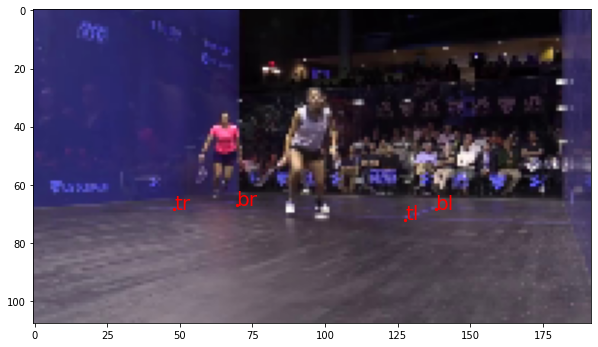

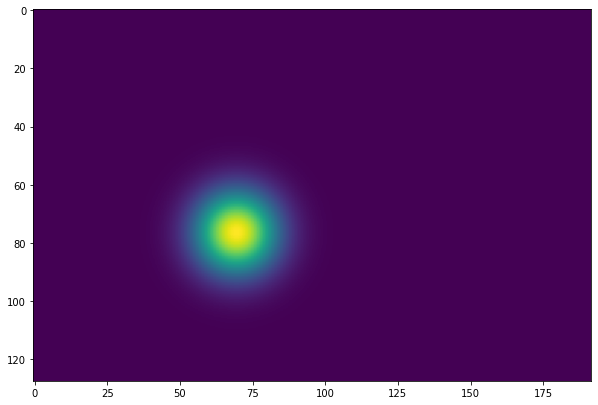

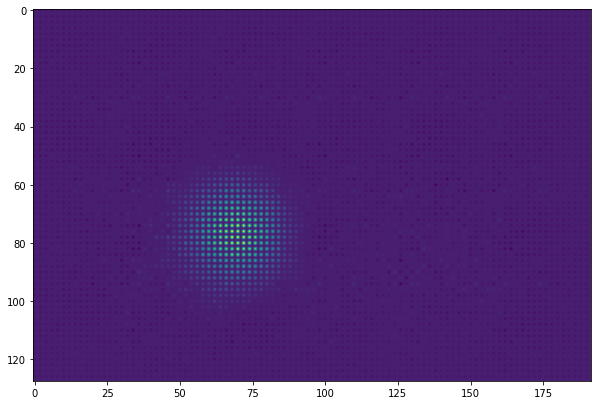

In [34]:
n = 290
p = 2

plot_image(train_input[n], heatmap_to_box(test_preds[n, 10:-10, :, :]))
plot_image(train_output[n, :, :, p])
plot_image(test_preds[n, :, :, p])

## Model Restore

In [27]:
#MODEL_FILE = BEST_MODEL_FILE
MODEL_FILE = LAST_MODEL_FILE

restore(MODEL_FILE)
model = load_model(MODEL_FILE)

## Predictions on New Data

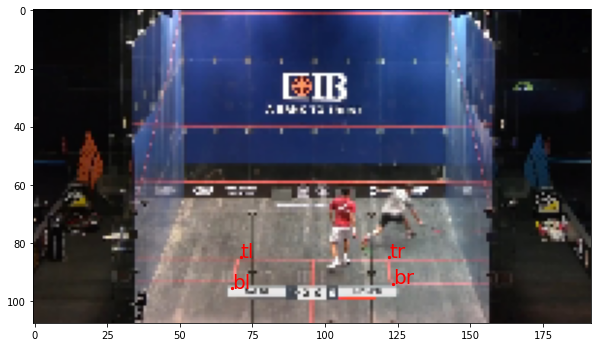

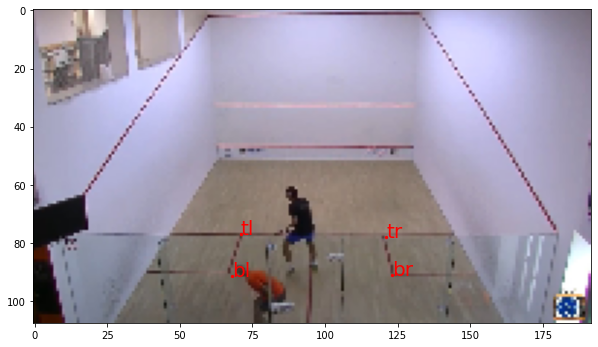

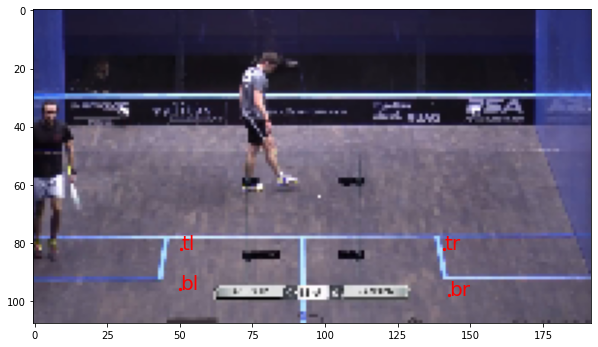

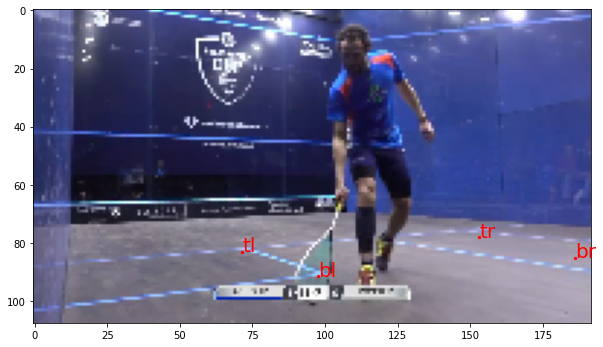

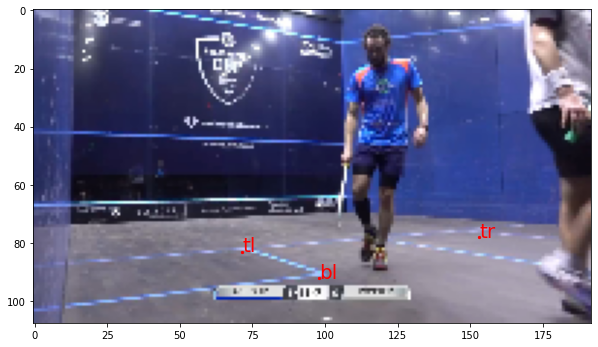

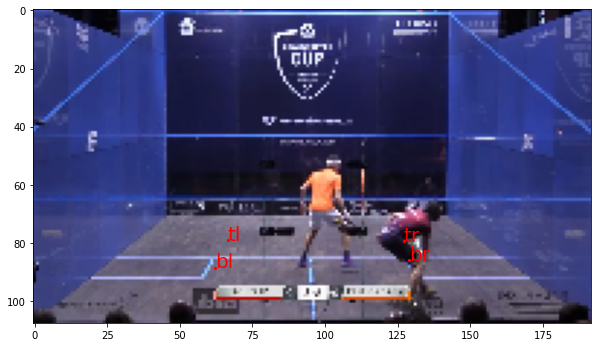

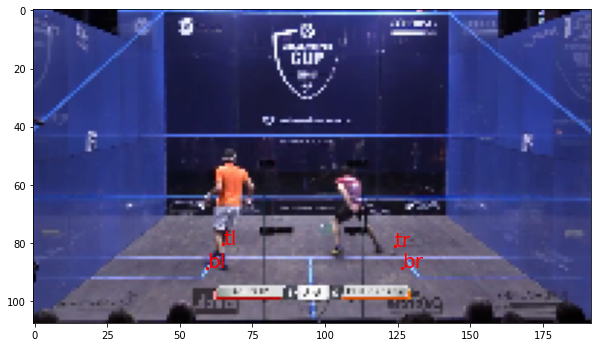

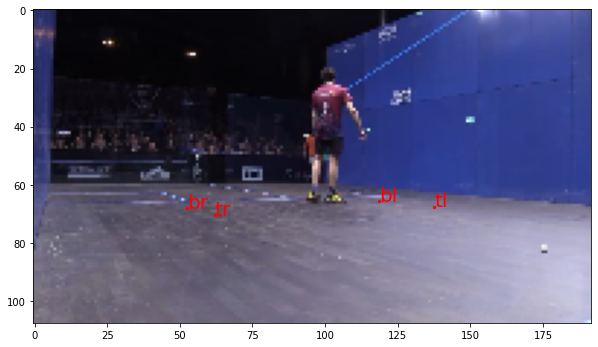

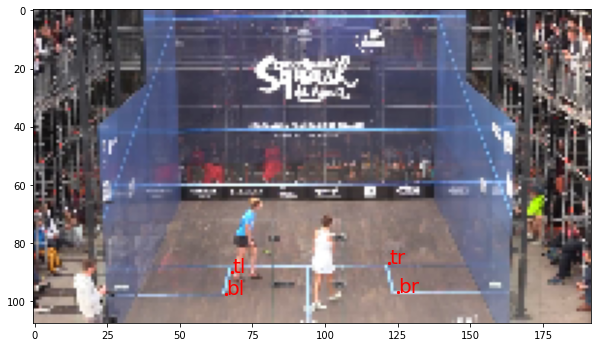

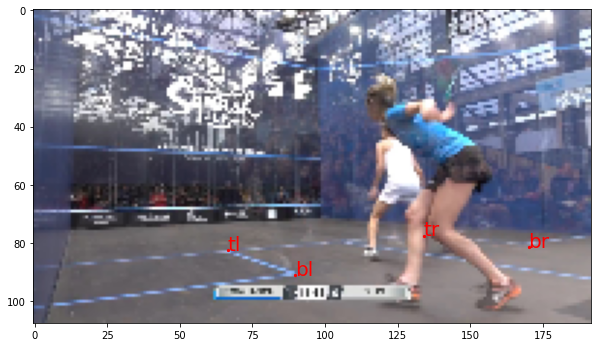

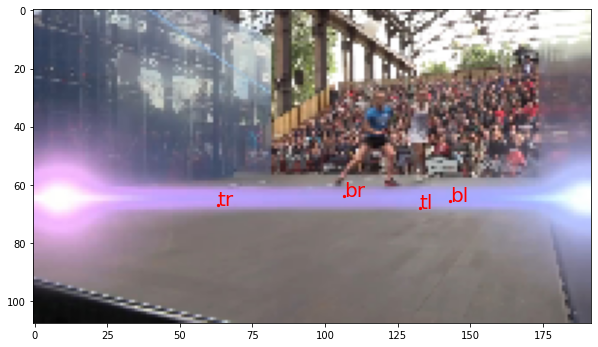

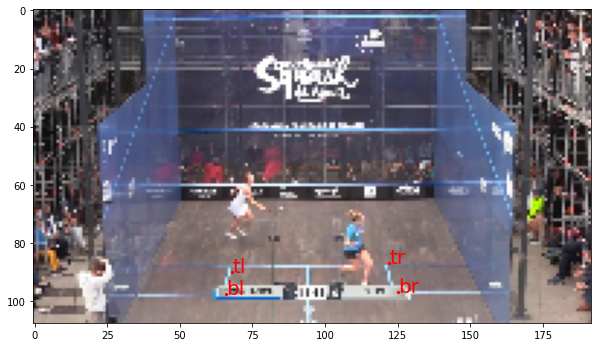

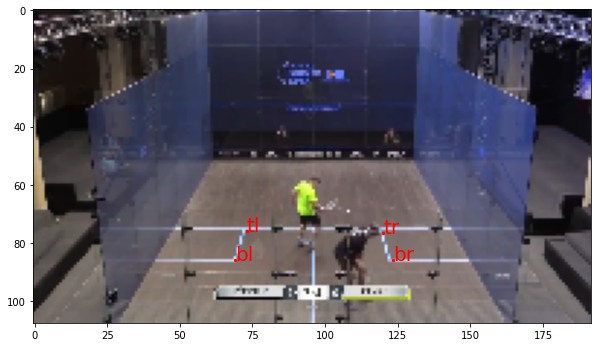

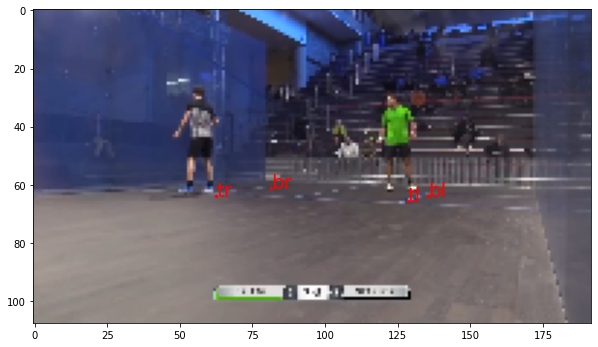

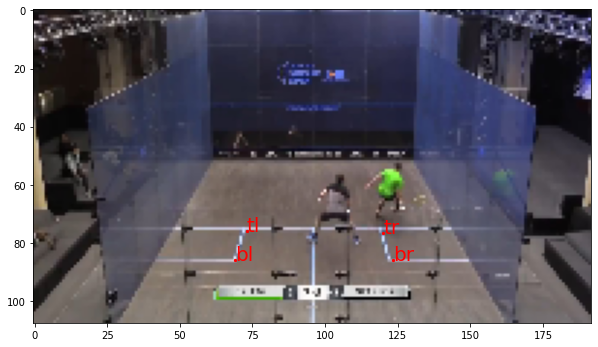

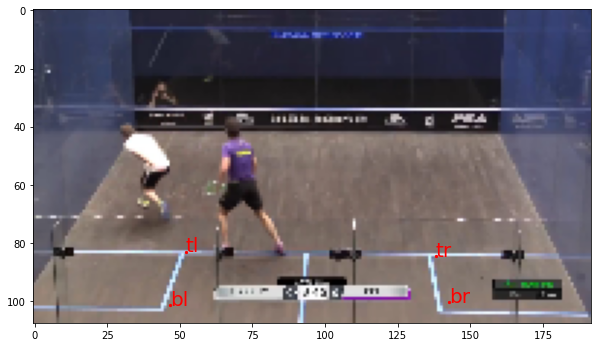

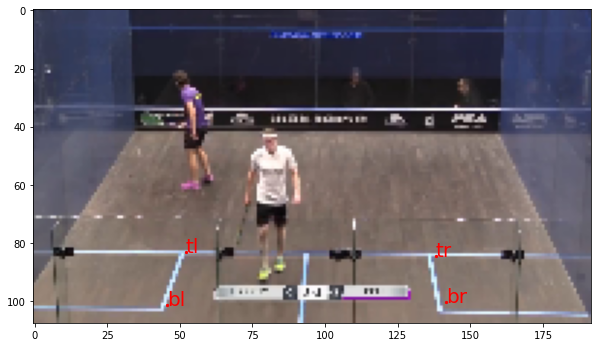

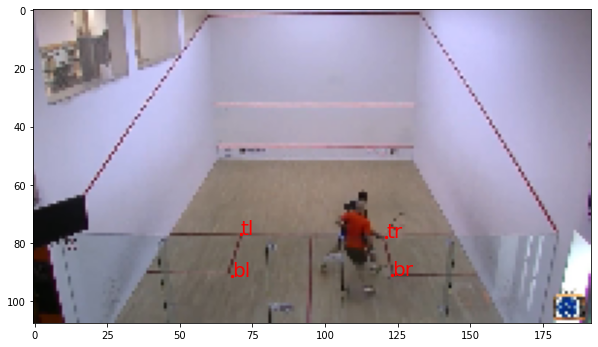

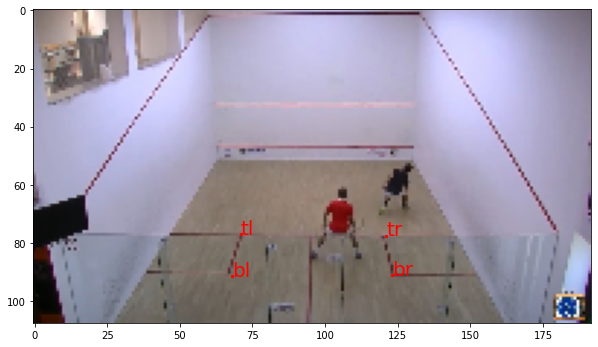

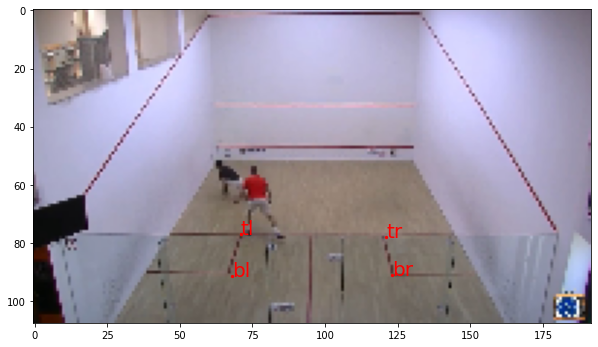

In [35]:
FRAMES_PATH = '../drive/My Drive/colab-data'

for idx in range(1, 21):
    frame = mpimg.imread(os.path.join(FRAMES_PATH,
                                      'frame-%d.jpg' % idx))
    frame = scale(frame, np.shape(train_input)[1:3])
    pred = model.predict(np.array([frame]))

    plot_image(frame, heatmap_to_box(pred[0, 10:-10, :, :], threshold=0.1))

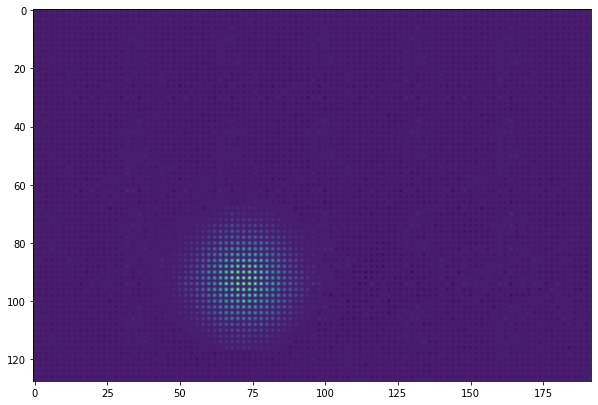

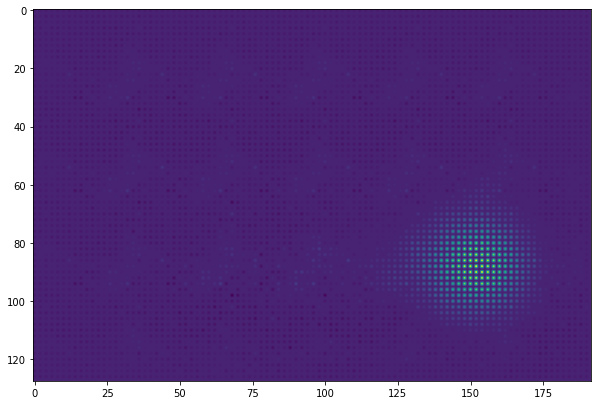

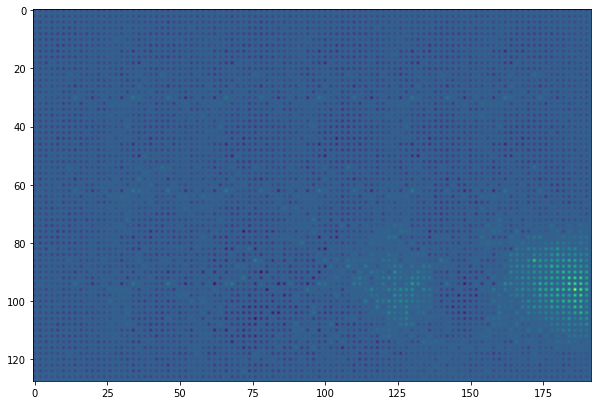

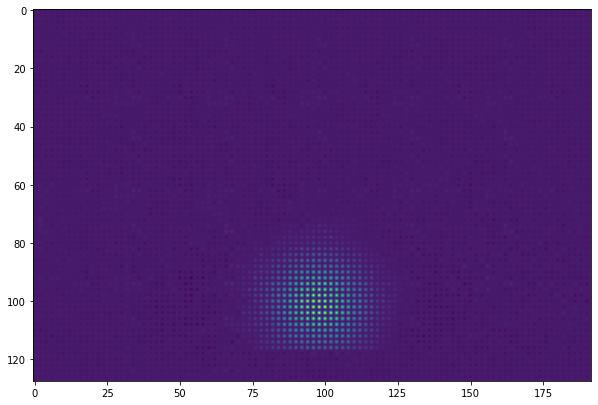

In [36]:
FRAMES_PATH = '../drive/My Drive/colab-data'

frame = mpimg.imread(os.path.join(FRAMES_PATH, 'frame-4.jpg'))
frame = scale(frame, np.shape(train_input)[1:3])
pred = model.predict(np.array([frame]))
for p in range(4):
    plot_image(pred[0, :, :, p])